In [ ]:
pip install xgboost lightgbm catboost sklego

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklego.linear_model import LADRegression

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [231]:
train = pd.read_csv('train.csv').drop(columns = ['id'])
test = pd.read_csv('test.csv').drop(columns = ['id'])
sub = pd.read_csv('sample_submission.csv')
original = pd.read_csv('original.csv')

train = pd.concat([train, original], axis = 0).reset_index(drop = True)

## Rounding

In [105]:
new = pd.read_csv('submissions/Ensemble_submission.csv')

In [106]:
new.head()

,id,Age
0,74051,7.410917
1,74052,7.895183
2,74053,10.295785
3,74054,8.977800
4,74055,7.188753


In [107]:
new['Age'] = np.round(new['Age']).astype(int)
new.head()

,id,Age
0,74051,7
1,74052,8
2,74053,10
3,74054,9
4,74055,7


In [108]:
new.to_csv('submissions/Ensemble_rounded.csv', index = False)

## Exploratory Data Analysis:

In [220]:
train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [221]:
train.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000
mean,1.317153,1.024316,0.348154,23.394310,10.109418,5.062290,6.727465,9.967156
std,0.288404,0.237949,0.092723,12.713088,5.652666,2.809131,3.603159,3.177472
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.150000,0.887500,0.287500,13.395139,5.712424,2.849125,3.940580,8.000000
50%,1.375000,1.075000,0.362500,23.728531,9.879801,4.975337,6.874754,10.000000
75%,1.537500,1.200000,0.412500,32.162508,14.047177,7.002326,9.086015,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


In [222]:
print(train.shape)
print(test.shape)

(77944, 9)
(49368, 8)


In [223]:
print(train.isna().sum())
print('\n', test.isna().sum())

Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

 Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
dtype: int64


In [224]:
train.drop(columns = ['Sex']).corr()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
Length,1.000000,0.989285,0.912514,0.935655,0.914366,0.916863,0.915757,0.609776
Diameter,0.989285,1.000000,0.915725,0.937458,0.912876,0.917149,0.921620,0.618737
Height,0.912514,0.915725,1.000000,0.896341,0.858228,0.877494,0.897728,0.632889
Weight,0.935655,0.937458,0.896341,1.000000,0.971127,0.970724,0.964912,0.597640
Shucked Weight,0.914366,0.912876,0.858228,0.971127,1.000000,0.941930,0.908695,0.498437
Viscera Weight,0.916863,0.917149,0.877494,0.970724,0.941930,1.000000,0.932237,0.572442
Shell Weight,0.915757,0.921620,0.897728,0.964912,0.908695,0.932237,1.000000,0.661228
Age,0.609776,0.618737,0.632889,0.597640,0.498437,0.572442,0.661228,1.000000


In [234]:
train.drop(columns = ['Sex']).corr()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Accounted Weight,Too Heavy,Shucked Weight Perc.,Viscera Weight Perc.,Shell Weight Perc.,New_Weight,Test_Too_Heavy
Length,1.000000,0.989285,0.912514,0.935655,0.917110,0.918365,0.918480,0.609776,0.937980,-0.167066,0.038489,-0.033584,-0.221337,0.938262,NaN
Diameter,0.989285,1.000000,0.915725,0.937458,0.915860,0.918804,0.924199,0.618737,0.939127,-0.168252,0.029914,-0.036325,-0.208286,0.939522,NaN
Height,0.912514,0.915725,1.000000,0.896341,0.861686,0.878918,0.898181,0.632889,0.896118,-0.154048,-0.010587,-0.025544,-0.143319,0.896174,NaN
Weight,0.935655,0.937458,0.896341,1.000000,0.975604,0.974299,0.969635,0.597640,0.993124,-0.178964,0.013171,-0.041191,-0.244397,0.995201,NaN
Shucked Weight,0.917110,0.915860,0.861686,0.975604,1.000000,0.947618,0.917420,0.507661,0.982186,-0.176644,0.119536,-0.053743,-0.316980,0.984493,NaN
Viscera Weight,0.918365,0.918804,0.878918,0.974299,0.947618,1.000000,0.938606,0.575424,0.976275,-0.176179,0.002420,0.114205,-0.254502,0.978455,NaN
Shell Weight,0.918480,0.924199,0.898181,0.969635,0.917420,0.938606,1.000000,0.657555,0.966635,-0.174814,-0.049370,-0.056996,-0.075146,0.968212,NaN
Age,0.609776,0.618737,0.632889,0.597640,0.507661,0.575424,0.657555,1.000000,0.578228,-0.140768,-0.187655,-0.048309,0.092222,0.581050,NaN
Accounted Weight,0.937980,0.939127,0.896118,0.993124,0.982186,0.976275,0.966635,0.578228,1.000000,-0.128983,0.067438,-0.002146,-0.220911,0.997895,NaN
Too Heavy,-0.167066,-0.168252,-0.154048,-0.178964,-0.176644,-0.176179,-0.174814,-0.140768,-0.128983,1.000000,0.255409,0.316049,0.289517,-0.179908,NaN


In [233]:
train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Accounted Weight,Too Heavy,Shucked Weight Perc.,Viscera Weight Perc.,Shell Weight Perc.,New_Weight,Test_Too_Heavy
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,27.725811,0,0.439335,0.229452,0.288160,27.725811,0
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,10.248344,0,0.434014,0.223129,0.326531,10.248344,0
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,23.558434,0,0.457666,0.224256,0.268879,23.558434,0
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,46.343665,0,0.401791,0.216970,0.296027,46.343665,0
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,22.438629,0,0.514303,0.193548,0.255630,22.438629,0


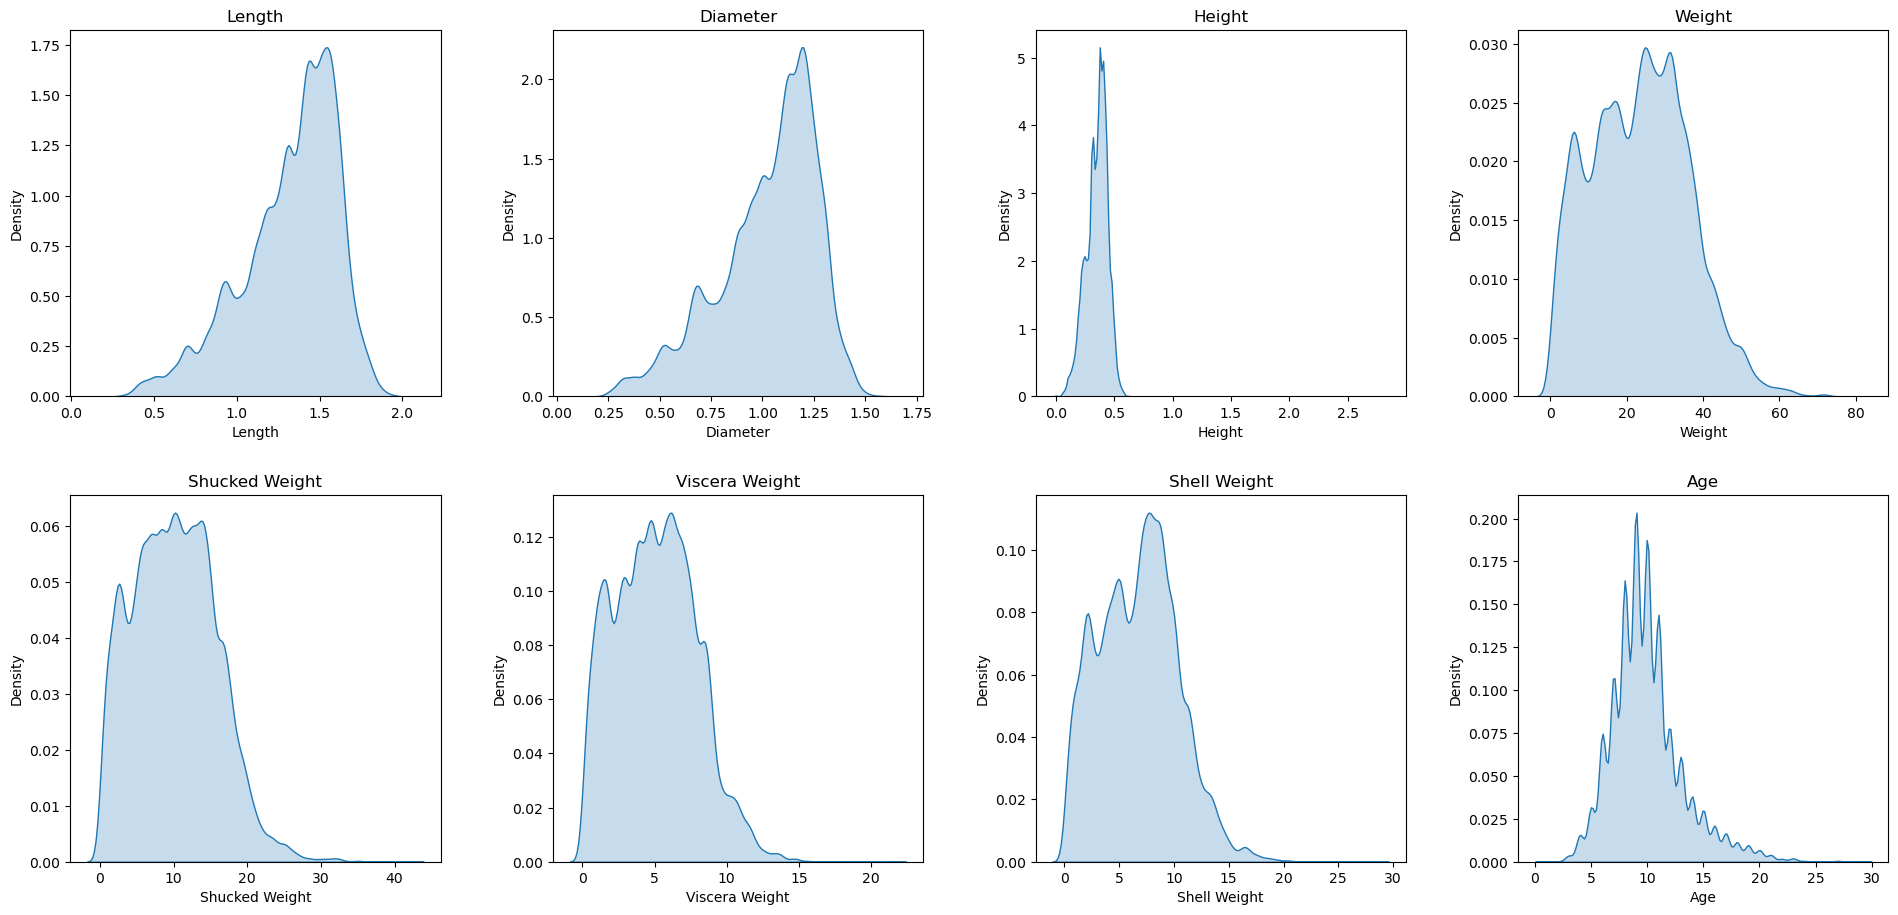

In [155]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))
plt.tight_layout(pad = 5)

sns.kdeplot(ax = axes[0, 0], data = train, x = 'Length', fill = True).set_title('Length')
sns.kdeplot(ax = axes[0, 1], data = train, x = 'Diameter', fill = True).set_title('Diameter')
sns.kdeplot(ax = axes[0, 2], data = train, x = 'Height', fill = True).set_title('Height')
sns.kdeplot(ax = axes[0, 3], data = train, x = 'Weight', fill = True).set_title('Weight')
sns.kdeplot(ax = axes[1, 0], data = train, x = 'Shucked Weight', fill = True).set_title('Shucked Weight')
sns.kdeplot(ax = axes[1, 1], data = train, x = 'Viscera Weight', fill = True).set_title('Viscera Weight')
sns.kdeplot(ax = axes[1, 2], data = train, x = 'Shell Weight', fill = True).set_title('Shell Weight')
sns.kdeplot(ax = axes[1, 3], data = train, x = 'Age', fill = True).set_title('Age')
plt.show()

## Cleaning

## Feature Engineering and Cleaning:

In [185]:
train['Male'] = np.where(train['Sex'] == 'M', 1, 0); train['Female'] = np.where(train['Sex'] == 'F', 1, 0)
test['Male'] = np.where(test['Sex'] == 'M', 1, 0); test['Female'] = np.where(test['Sex'] == 'F', 1, 0)

In [186]:
train['Shucked Weight Perc.'] = train['Shucked Weight'] / train['Weight']
train['Viscera Weight Perc.'] = train['Viscera Weight'] / train['Weight']
train['Shell Weight Perc.'] = train['Shell Weight'] / train['Weight']
train['Shucked Weight'] = np.where(train['Shucked Weight Perc.'] > 1, train['Weight'] - train['Shell Weight'] - train['Viscera Weight'], 
                                   train['Shucked Weight'])
train['Viscera Weight'] = np.where(train['Viscera Weight Perc.'] > 1, train['Weight'] - train['Shucked Weight'] - train['Shell Weight'], 
                                   train['Viscera Weight'])
train['Shell Weight'] = np.where(train['Shell Weight Perc.'] > 1, train['Weight'] - train['Shucked Weight'] - train['Viscera Weight'], 
                                   train['Shell Weight'])
train['Shucked Weight Perc.'] = train['Shucked Weight'] / train['Weight']
train['Viscera Weight Perc.'] = train['Viscera Weight'] / train['Weight']
train['Shell Weight Perc.'] = train['Shell Weight'] / train['Weight']


test['Shucked Weight Perc.'] = test['Shucked Weight'] / test['Weight']
test['Viscera Weight Perc.'] = test['Viscera Weight'] / test['Weight']
test['Shell Weight Perc.'] = test['Shell Weight'] / test['Weight']
test['Shucked Weight'] = np.where(test['Shucked Weight Perc.'] > 1, test['Weight'] - test['Shell Weight'] - test['Viscera Weight'], 
                                   test['Shucked Weight'])
test['Viscera Weight'] = np.where(test['Viscera Weight Perc.'] > 1, test['Weight'] - test['Shucked Weight'] - test['Shell Weight'], 
                                   test['Viscera Weight'])
test['Shell Weight'] = np.where(test['Shell Weight Perc.'] > 1, test['Weight'] - test['Shucked Weight'] - test['Viscera Weight'], 
                                   test['Shell Weight'])
test['Shucked Weight Perc.'] = test['Shucked Weight'] / test['Weight']
test['Viscera Weight Perc.'] = test['Viscera Weight'] / test['Weight']
test['Shell Weight Perc.'] = test['Shell Weight'] / test['Weight']

In [232]:
train['Accounted Weight'] = train['Shucked Weight'] + train['Viscera Weight'] + train['Shell Weight']
train['Too Heavy'] = np.where(train['Accounted Weight'] > train['Weight'], 1, 0)
train['Shucked Weight Perc.'] = train['Shucked Weight'] / train['Weight']
train['Viscera Weight Perc.'] = train['Viscera Weight'] / train['Weight']
train['Shell Weight Perc.'] = train['Shell Weight'] / train['Weight']

train['Shucked Weight'] = np.where(train['Too Heavy'] == 1, 0.424150 * train['Weight'], train['Shucked Weight'])
train['Viscera Weight'] = np.where(train['Too Heavy'] == 1, 0.213569 * train['Weight'], train['Viscera Weight'])
train['Shell Weight'] = np.where(train['Too Heavy'] == 1, 0.288712 * train['Weight'], train['Shell Weight'])
train['New_Weight'] = train['Shucked Weight'] + train['Viscera Weight'] + train['Shell Weight']
train['Test_Too_Heavy'] = np.where(train['Weight'] < train['New_Weight'], 1, 0)




test['Accounted Weight'] = test['Shucked Weight'] + test['Viscera Weight'] + test['Shell Weight']
test['Too Heavy'] = np.where(test['Accounted Weight'] > test['Weight'], 1, 0)
test['Shucked Weight Perc.'] = test['Shucked Weight'] / test['Weight']
test['Viscera Weight Perc.'] = test['Viscera Weight'] / test['Weight']
test['Shell Weight Perc.'] = test['Shell Weight'] / test['Weight']






In [158]:
train['Accounted Weight'] = train['Shucked Weight'] + train['Viscera Weight'] + train['Shell Weight']
train['Height'] = np.where(train['Height'] < 0.01, 0.01, train['Height'])
train['Volume'] = train['Length'] * train['Diameter'] * train['Height']
train['Density'] = train['Weight'] / train['Volume']

test['Accounted Weight'] = test['Shucked Weight'] + test['Viscera Weight'] + test['Shell Weight']
test['Height'] = np.where(test['Height'] < 0.01, 0.01, test['Height'])
test['Volume'] = test['Length'] * test['Diameter'] * test['Height']
test['Density'] = test['Weight'] / test['Volume']

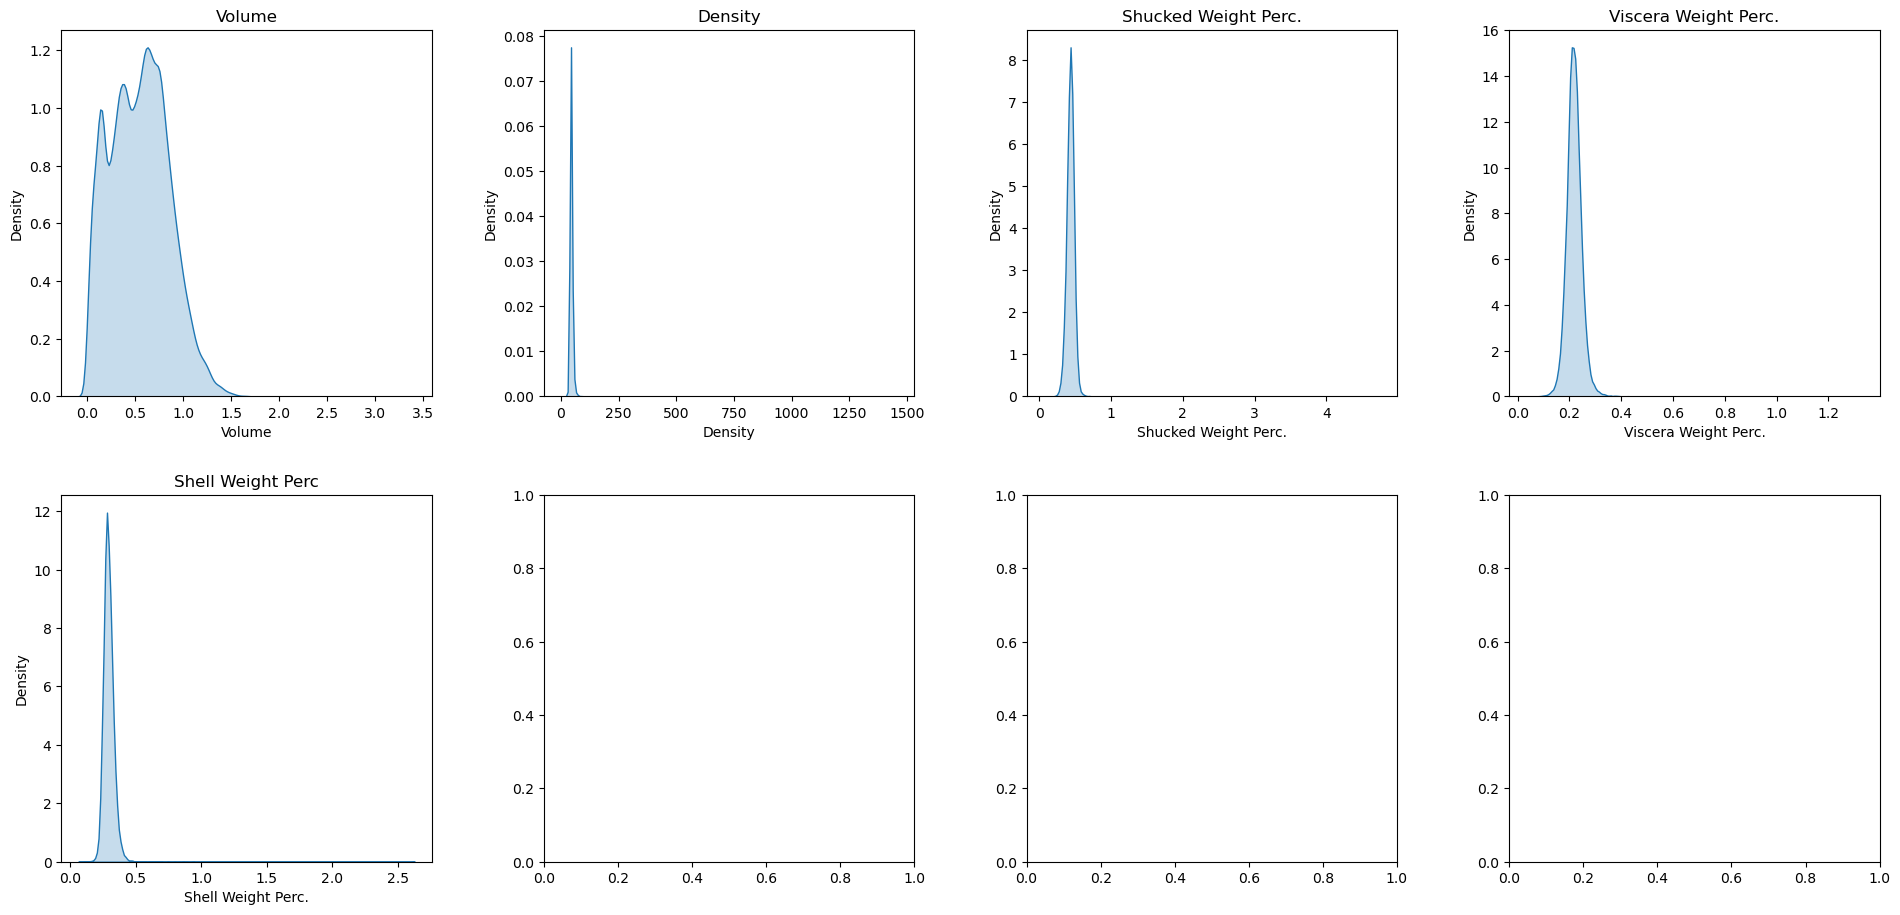

In [128]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))
plt.tight_layout(pad = 5)

sns.kdeplot(ax = axes[0, 0], data = train, x = 'Volume', fill = True).set_title('Volume')
sns.kdeplot(ax = axes[0, 1], data = train, x = 'Density', fill = True).set_title('Density')
sns.kdeplot(ax = axes[0, 2], data = train, x = 'Shucked Weight Perc.', fill = True).set_title('Shucked Weight Perc.')
sns.kdeplot(ax = axes[0, 3], data = train, x = 'Viscera Weight Perc.', fill = True).set_title('Viscera Weight Perc.')
sns.kdeplot(ax = axes[1, 0], data = train, x = 'Shell Weight Perc.', fill = True).set_title('Shell Weight Perc')
plt.show()

In [205]:
train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Accounted Weight,Too Heavy,Shucked Weight Perc.,Viscera Weight Perc.,Shell Weight Perc.
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,27.725811,0,0.439335,0.229452,0.288160
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,10.248344,0,0.434014,0.223129,0.326531
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,23.558434,0,0.457666,0.224256,0.268879
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,46.343665,0,0.401791,0.216970,0.296027
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,22.438629,0,0.514303,0.193548,0.255630


In [196]:
train.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Accounted Weight
count,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000,77944.000000
mean,1.317153,1.024316,0.348154,23.394310,10.109418,5.062290,6.727465,9.967156,21.899173
std,0.288404,0.237949,0.092723,12.713088,5.652666,2.809131,3.603159,3.177472,11.774035
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000,0.085048
25%,1.150000,0.887500,0.287500,13.395139,5.712424,2.849125,3.940580,8.000000,12.686401
50%,1.375000,1.075000,0.362500,23.728531,9.879801,4.975337,6.874754,10.000000,22.140960
75%,1.537500,1.200000,0.412500,32.162508,14.047177,7.002326,9.086015,11.000000,30.348140
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000,76.331029


In [206]:
train.groupby('Too Heavy')[['Shucked Weight Perc.', 'Viscera Weight Perc.', 'Shell Weight Perc.']].describe()

Shucked Weight Perc.                                          \
                         count      mean       std       min       25%   
Too Heavy                                                                
0                      68869.0  0.424150  0.047913  0.083333  0.394477   
1                       9075.0  0.487791  0.184017  0.250000  0.445218   

                                        Viscera Weight Perc.            ...  \
                50%       75%       max                count      mean  ...   
Too Heavy                                                               ...   
0          0.427184  0.456736  0.602740              68869.0  0.213569  ...   
1          0.475480  0.508366  4.725118               9075.0  0.243667  ...   

                              Shell Weight Perc.                      \
                75%       max              count      mean       std   
Too Heavy                                                              
0          0.230182  0.444444            68869.0  0.288712  0.034788   
1          0.259355  1.323630             9075.0  0.325949  0.064868   

                                                             
                min       25%       50%       75%       max  
Too Heavy                                                    
0          0.075472  0.265557  0.286344  0.310036  0.494845  
1          0.189573  0.291758  0.318091  0.348537  2.615672  

[2 rows x 24 columns]

In [217]:
train['Test_Shucked'] = np.where(train['Too Heavy'] == 1, 0.424150*train['Weight'], 0)
train['Test_Viscera'] = np.where(train['Too Heavy'] == 1, 0.213569*train['Weight'], 0)
train['Test_Shell'] = np.where(train['Too Heavy'] == 1, 0.288712*train['Weight'], 0)
train['Test_Weight'] = train['Test_Shucked'] + train['Test_Viscera'] + train['Test_Shell']
train['Test_Too_Heavy'] = np.where(train['Weight'] < train['Test_Weight'], 1, 0)

In [218]:
train[train['Test_Too_Heavy'] == 1]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Accounted Weight,Too Heavy,Shucked Weight Perc.,Viscera Weight Perc.,Shell Weight Perc.,Test_Shucked,Test_Viscera,Test_Shell,Test_Weight,Test_Too_Heavy


In [144]:
train['Too Heavy'] = np.where(train['Accounted Weight'] > train['Weight'], 1, 0)

In [ ]:
train[train['Accounted Weight'] > (train['Weight'] + 5)]

In [146]:
train.groupby('Too Heavy')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Too Heavy,,,,,,,,
0,68869.0,10.129521,3.192082,1.0,8.0,10.0,11.0,29.0
1,9075.0,8.734986,2.769955,1.0,7.0,8.0,10.0,29.0


In [189]:
test[test['Shucked Weight Perc.'] > 1]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Male,Female,Shucked Weight Perc.,Viscera Weight Perc.,Shell Weight Perc.,Accounted Weight


In [177]:
train['Shucked Weight'] = np.where(train['Shucked Weight Perc.'] > 1, train['Weight'] - train['Shell Weight'] - train['Viscera Weight'], 
                                   train['Shucked Weight'])
train['Viscera Weight'] = np.where(train['Viscera Weight Perc.'] > 1, train['Weight'] - train['Shucked Weight'] - train['Shell Weight'], 
                                   train['Viscera Weight'])
train['Shell Weight'] = np.where(train['Shell Weight Perc.'] > 1, train['Weight'] - train['Shucked Weight'] - train['Viscera Weight'], 
                                   train['Shell Weight'])

In [191]:
test[test['Shell Weight Perc.'] > 1]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Male,Female,Shucked Weight Perc.,Viscera Weight Perc.,Shell Weight Perc.,Accounted Weight
41050,F,1.625,1.325,0.475,4.918638,-14.840963,10.560189,9.199413,0,1,-3.017291,2.146974,1.870317,4.918638


In [181]:
train[train['Viscera Weight Perc.'] > 1]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Male,Female,Shucked Weight Perc.,Viscera Weight Perc.,Shell Weight Perc.


In [131]:
3.798833 * 3

11.396499

In [72]:
numeric_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 
                    'Shell Weight', 'Shucked Weight Perc.', 'Viscera Weight Perc.', 'Shell Weight Perc.']

scaler = StandardScaler().fit(train[numeric_features])
X_train = scaler.transform(train[numeric_features])
X_test = scaler.transform(test[numeric_features])

pca = PCA(0.9).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca = pd.DataFrame(X_train_pca, columns = ['PC_1', 'PC_2', 'PC_3', 'PC_4'])
X_test_pca = pd.DataFrame(X_test_pca, columns = ['PC_1', 'PC_2', 'PC_3', 'PC_4'])

train = pd.concat([train, X_train_pca], axis = 1)
test = pd.concat([test, X_test_pca], axis = 1)

In [ ]:
# grouped = train.groupby('Sex')['Shucked Weight'].agg([np.min, np.max, np.median, np.mean]).reset_index()
# grouped.columns = ['Sex','min_price_by_pos', 'max_price_by_pos','median_price_by_pos','mean_price_by_pos']

# ## Adding aggregated price info
# full_data = pd.merge(full_data, price_by_pos, how = 'left', on = 'pos')

## Hyper-parameter Tuning:

## Modelling:

In [88]:
xgb_params = {'n_estimators': 1000, 
              'learning_rate': 0.00482382842096919, 
              'booster': 'gbtree', 
              'lambda': 0.000235366507474591, 
              'alpha': 0.0000115977765684837, 
              'subsample': 0.35955930593108, 
              'colsample_bytree': 0.898528184386095, 
              'max_depth': 9, 
              'min_child_weight': 8, 
              'eta': 0.0000784943239744148, 
              'gamma': 1.6661346939401E-07, 
              'grow_policy': 'lossguide', 
              'n_jobs': -1, 
              'objective': 'reg:squarederror',
              'eval_metric': 'mae', 
              'verbosity': 0}

lgb1_params = {'n_estimators': 1000,
               'learning_rate': 0.00659605502010782,
               "reg_alpha": 0.0134568843414818,
               "reg_lambda": 2.38367559632979E-06,
               "num_leaves": 117,
               "colsample_bytree": 0.850706320762174,
               'subsample': 0.691827302225948,
               'subsample_freq': 4,
               'min_child_samples': 33,
               'objective': 'regression_l2',
               'metric': 'mae',
               'boosting_type': 'gbdt'}

cat1_params = {'iterations': 1000,
               'depth': 7,
               'learning_rate': 0.00454306521731278,
               'l2_leaf_reg': 0.113774158297261,
               'random_strength': 0.0179641854849499,
               'od_type': 'IncToDec',
               'od_wait': 50,
               'bootstrap_type': 'Bayesian',
               'grow_policy': 'Lossguide',
               'bagging_temperature': 1.39240858193441,
               'eval_metric': 'MAE',
               'loss_function': 'MAE',
               'verbose': False,
               'allow_writing_files': False}

hist_params = {'loss': 'absolute_error',
               'l2_regularization': 0.0104104133357932,
               'early_stopping': True,
               'learning_rate': 0.00627298859709192,
               'max_iter': 1000,
               'n_iter_no_change': 200,
               'max_depth': 16,
               'max_bins': 255,
               'min_samples_leaf': 54,
               'max_leaf_nodes':57}

gbd_params = {'loss': 'absolute_error',
              'n_estimators': 800,
              'max_depth': 10,
              'learning_rate': 0.01,
              'min_samples_split': 10,
              'min_samples_leaf': 20}

models = {"xgb": XGBRegressor(**xgb_params),
          "lgb": LGBMRegressor(**lgb1_params),
          "cat": CatBoostRegressor(**cat1_params),
          'hgb': HistGradientBoostingRegressor(**hist_params),
          "SVR_rbf": SVR(kernel="rbf", gamma="auto"),
          "RandomForestRegressor": RandomForestRegressor(n_estimators=500, n_jobs=-1),
          "GradientBoostingRegressor": GradientBoostingRegressor(**gbd_params)}

In [99]:
models

{'xgb': XGBRegressor(alpha=1.15977765684837e-05, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.898528184386095, early_stopping_rounds=None,
              enable_categorical=False, eta=7.84943239744148e-05,
              eval_metric='mae', feature_types=None, gamma=1.6661346939401e-07,
              gpu_id=None, grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, lambda=0.000235366507474591,
              learning_rate=0.00482382842096919, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, ...),
 'lgb': LGBMRegressor(colsample_bytree=0.850706320762174,
               learning_rate=0.00659605502010782, metric='mae',
               min_child_samples

In [ ]:
## Dropping some variables
train.drop(columns = ['Sex'], axis = 1, inplace = True)
test.drop(columns = ['id', 'Sex'], axis = 1, inplace = True)

## Defining the input and target variables
X = train.drop(columns = ['Age'], axis = 1)
Y = train['Age']

## Defining lists to store results
gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

## Performing KFold cross-validation
skf = KFold(n_splits = 10, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(skf.split(X, Y)):
        
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
    print('---------------------------------------------------------------')
    
    ######################
    ## GradientBoosting ##
    ######################
        
    gb_md = GradientBoostingRegressor(loss = 'absolute_error', n_estimators = 1000, max_depth = 8, learning_rate = 0.01,
                                      min_samples_split = 10, min_samples_leaf = 20).fit(X_train, Y_train) 
    
    gb_pred_1 = gb_md.predict(X_test[X_test['generated'] == 1])
    gb_pred_2 = gb_md.predict(test)
    
    gb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], gb_pred_1)
    gb_cv_scores.append(gb_score_fold)
    gb_preds.append(gb_pred_2)
    
    print('Fold', i, '==> GradientBoositng oof MAE is ==>', gb_score_fold)
    
    
    ##########################
    ## HistGradientBoosting ##
    ##########################
        
    hist_md = HistGradientBoostingRegressor(loss = 'absolute_error', l2_regularization = 0.01, early_stopping = False, learning_rate = 0.01,
                                            max_iter = 1000, max_depth = 15, max_bins = 255, min_samples_leaf = 30, 
                                            max_leaf_nodes = 30).fit(X_train, Y_train)
    
    hist_pred_1 = hist_md.predict(X_test[X_test['generated'] == 1])
    hist_pred_2 = hist_md.predict(test)

    hist_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], hist_pred_1)
    hist_cv_scores.append(hist_score_fold)
    hist_preds.append(hist_pred_2)
    
    print('Fold', i, '==> HistGradient oof MAE is ==>', hist_score_fold)
        
    ##############
    ## LightGBM ##
    ##############
        
    lgb_md = LGBMRegressor(objective = 'mae', n_estimators = 1000, max_depth = 10, learning_rate = 0.01, num_leaves = 70, reg_alpha = 3,
                           reg_lambda = 3, subsample = 0.7, colsample_bytree = 0.7).fit(X_train, Y_train)
    
    lgb_pred_1 = lgb_md.predict(X_test[X_test['generated'] == 1])
    lgb_pred_2 = lgb_md.predict(test)

    lgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], lgb_pred_1)    
    lgb_cv_scores.append(lgb_score_fold)
    lgb_preds.append(lgb_pred_2)
    
    print('Fold', i, '==> LightGBM oof MAE is ==>', lgb_score_fold)
        
    #############
    ## XGBoost ##
    #############
        
    xgb_md = XGBRegressor(objective = 'reg:pseudohubererror', colsample_bytree = 0.7, gamma = 0.8, learning_rate = 0.01, max_depth = 8, 
                          min_child_weight = 20, n_estimators = 1000, subsample = 0.7).fit(X_train, Y_train)
    
    xgb_pred_1 = xgb_md.predict(X_test[X_test['generated'] == 1])
    xgb_pred_2 = xgb_md.predict(test)

    xgb_score_fold = mean_absolute_error(Y_test[X_test['generated'] == 1], xgb_pred_1)    
    xgb_cv_scores.append(xgb_score_fold)
    xgb_preds.append(xgb_pred_2)
    
    print('Fold', i, '==> XGBoost oof MAE is ==>', xgb_score_fold)
    
    ##################
    ## LAD Ensemble ##
    ##################
    
    x = pd.DataFrame({'GBC':gb_pred_1,  'hist': hist_pred_1, 'lgb': lgb_pred_1, 'xgb': xgb_pred_1})
    y = Y_test[X_test['generated'] == 1]
    
    lad_md = LADRegression().fit(x, y)
    lad_pred = lad_md.predict(x)
    
    x_test = pd.DataFrame({'GBC':gb_pred_2,  'hist': hist_pred_2, 'lgb': lgb_pred_2, 'xgb': xgb_pred_2})
    lad_pred_test = lad_md.predict(x_test)
        
    ens_score = mean_absolute_error(y, lad_pred)
    ens_cv_scores.append(ens_score)
    ens_preds.append(lad_pred_test)
    
    print('Fold', i, '==> LAD ensemble oof MAE is ==>', ens_score)

In [122]:
print(np.mean(gb_cv_scores))
print(np.mean(hist_cv_scores))
print(np.mean(lgb_cv_scores))
print(np.mean(xgb_cv_scores))
print(np.mean(ens_cv_scores))

1.3587006251623799
1.3676792385295615
1.3530778289498537
1.3640297074504832
1.3519540332296613


In [123]:
gb_preds_test = pd.DataFrame(gb_preds).apply(np.mean, axis = 0)
hist_preds_test = pd.DataFrame(hist_preds).apply(np.mean, axis = 0)
lgb_preds_test = pd.DataFrame(lgb_preds).apply(np.mean, axis = 0)
xgb_preds_test = pd.DataFrame(xgb_preds).apply(np.mean, axis = 0)
ens_preds_test = pd.DataFrame(ens_preds).apply(np.mean, axis = 0)

sub['Age'] = gb_preds_test
sub.to_csv('submissions/GB_submission.csv', index = False)

sub['Age'] = hist_preds_test
sub.to_csv('submissions/Hist_submission.csv', index = False)

sub['Age'] = lgb_preds_test
sub.to_csv('submissions/LightGBM_submission.csv', index = False)

sub['Age'] = xgb_preds_test
sub.to_csv('submissions/XGBoost_submission.csv', index = False)

sub['Age'] = ens_preds_test
sub.to_csv('submissions/Ensemble_submission.csv', index = False)